# Quantum Network Utility: A Framework for Benchmarking Quantum Networks
August 2022

*Please feel free to make a copy of this notebook so that you can run it or make changes. This notebook can be found at the following link:* \
https://tinyurl.com/quantumNetworkUtility2022

*A draft of the corresponding paper can be found at:* \
https://tinyurl.com/quantumNetworkUtilityPaper2022

## Calculating Quantum Network Utility

In this notebook, we provide the code to compute the quantum network utility from distributed quantum computing for an arbitrary network. We also demonstrate how this code can be used, by computing the utility of an example network.

Recall that in the context of distributed quantum computing, the quantum network utility is a "quantum volume throughput". It extends the quantum volume of quantum computers to quantum networks. The metric we present here is one example of a network utility in the framework we have presented in the main text of the paper.

We make the following assumptions:
* Every node in the network has one memory allocated for computation. This is not a restrictive assumption: if a physical network node has multiple computation memories, we can construct virtual nodes with one memory each and the appropriate local links.
* The network only produces bipartite entanglement (i.e. Bell states).
* The network produces Bell states with zero error (i.e. $\epsilon_{\text{eff}} = 0$, and an entanglement swap generates new entanglement with efficiency $q$.
* The entanglement produced by the network is used for the Heavy Output Generation (HOG) computation task. Different coalitions of nodes are associated with distinct tasks.
* The utility of completing a computation task is the quantum volume associated with that task, which we can interpret as the cost of simulating the HOG problem on a classical computer.

### Setup

We assume that all elementary links in the quantum network can generate entanglement at some rate $f_{ab} = f$. We can perform entanglement swaps to convert elementary links into output entanglement with efficiency $q_c = q$ per swap. The rate region describing the set of feasible entanglement rate vectors can thus be defined by a set of linear constraints.

If $m$ memories perform a depth-$d$ HOG computation task, the associated utility is $\beta^{\min(m, d)}$, where $\beta = 2$. For generality, we let the base $\beta$ be a variable (`vol_scaling`).

To perform the HOG computation task with depth $d$ over a coalition of size $m$, we need an average of $d/(m-1)$ entanglements between every pair of nodes in the coalition if $m$ is even, and $d/m$ entanglements between every node pair if $m$ is odd.

Hence, utility from performing the HOG computation task is derived at the rate
$$ \beta^{\min(m, d)} \times \text{rate of HOG computations} = \beta^{\min(m, d)} \times \text{minimum entanglement rate over coalition node pairs} \times \left\{\!\begin{aligned}
&\textstyle\frac{m-1}{d} &\text{if } m \text{ is even}\\[1ex]
&\textstyle\frac{m}{d} &\text{if } m \text{ is odd} \\[1ex]
\end{aligned}\right\}.$$

The quantum network utility maximizes the sum of utilities over all possible coalitions of nodes. Note that $m, d$ and the "minimum entanglement rate over coalition node pairs" are specific to each coalition. For a HOG computation task to be performed, all node pairs in the coalition must have at least some entanglement rate specific to the coalition.

We now transform this optimization problem into a linear program.

First, note that $d$ should not be larger than $m$ in any optimal solution. Doing so increases the amount of entanglement needed to perform an HOG computation without increasing the associated quantum volume. Therefore, $\min(m, d) = d$.

Then, note that the utility term associated with any given coalition depends on its depth $d$ through the factor $\beta^d / d$.

Hence, we can choose the optimal value of $d$ for each coalition independently of the other variables to be optimized over. In particular, $\beta^d / d$ is a strictly convex function of $d$, so it is maximized at the endpoints $d = 1$ or $d = m$.

After fixing the value of $d$, the optimization problem is a straightforward linear program.

### Utilities

In this section, we import relevant packages and define a few useful functions.

This code requires external packages `numpy`, `ortools`, `matplotlib` and `networkx`. (The latter two packages are for plotting.)

In [1]:
# If ortools is installed, you can comment-out the following line:
# !pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 12.3 MB/s 
     |████████████████████████████████| 408 kB 52.7 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.5 which is incompatible.
tensorflow-metadata 1.9.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.5 which is incompatible.
google-cloud-bigquery-storage 1.1.2 requires protobuf<4.0.0dev, but you have protobuf 4.21.5 which is incompatible.
google-api-core 1.31.6 requires protobuf<4.0.0dev,>=3.12.0; python_version > "3", but you have proto

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations
from ortools.linear_solver import pywraplp
import time
import networkx as nx

This function defines a consistent convention for labelling edges in the network. Each edge is named according to the two nodes it connects.

In [3]:
get_edge = lambda i, j: (i, j) if i < j else (j, i)

Given a set `nodes` of nodes, this function constructs all possible entangled output states of the network.

In [4]:
def get_ecal(nodes):
    ecal = [get_edge(nodes[i1], nodes[i2]) for i1 in range(len(nodes)) \
                                    for i2 in range(i1+1, len(nodes))]
    return ecal

This function returns a generator that produces all possible coalitions of nodes in the network. Of course, we can choose different subsets of coalitions that we are interested in. For example, in the case of a repeater chain, it suffices to consider connected coalitions.

In [5]:
def gen_all_coalitions(nodes):
    max_coalition_size = len(nodes) + 1
    coalitions = chain.from_iterable(combinations(nodes, r) \
                                     for r in range(2, max_coalition_size))
    return coalitions

Now we define a few common parameters in this code.

In [6]:
# "eps_eff" parameter = error of generated entanglement.
eps_edge = 0
# "beta" parameter in the base of the quantum volume.
vol_scaling = 2

Even though the discussion above assumes that the network generates perfect Bell states (`eps_edge` = 0), the following code will also be valid for imperfect Bell states (`eps_edge` > 0).

### Defining a network

To define a network, we need to specify its nodes (`nodes`) and edges. These edges represent elementary links in the physical layer of the network.

The dictionary `f_edges` ($f$) describes the raw rates at which the network produces entanglement, in the absence of entanglement swaps. The keys of `f_edges` are the edges of the network.

The dictionary `q_nodes` ($q$) describes the efficiency with which each node in the network can perform entanglement swaps.

Recall that `ecal` is a list of all possible entangled output states of the network.

This function defines a uniform repeater chain with `chain_length` ($M$) nodes. The raw entanglement rate between adjacent nodes is normalized to $f = 0.6$ (arbitrary units) -- this parameter only affects the computed quantum network volume up to a scaling factor. All nodes are assumed to have the same entanglement swap efficiency.

In [7]:
def gen_params_chain(chain_length, q_node, vol_scaling):
    nodes = list(range(chain_length))
    edges = [(i, i+1) for i in range(chain_length-1)]
    f_edges = {s: 0.6 for s in edges}
    ecal = get_ecal(nodes)
    q_nodes = {node: q_node for node in nodes}
    return nodes, ecal, f_edges, q_nodes, vol_scaling

The function `gen_all_coalitions` from above returns generators that produces all possible coalitions of nodes in the network. However, the number of possible coalitions scales exponentially with the length of the repeater chain, so the optimization problem would not be feasible for moderately long repeater chains.

To reduce the size of the optimization problem, we note that the only computing tasks that will be performed at a positive rate in an optimal solution must involve connected coalitions of nodes. (A detailed proof is provided in the paper.) Therefore, we can restrict the set of coalitions to coalitions of connected nodes.

The following function returns generators that produces all connected coalitions of nodes in a repeater chain.

In [8]:
def gen_coalitions_chain(nodes):
    # Heuristic: only connected nodes can form a coalition.
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            yield tuple(range(i, j+1))

### Solving the optimization problem

The following code is arguably the most important in this notebook. It computes the quantum network utility by solving the linear program described above, and is applicable to any network that satisfies the assumptions in the preamble to this notebook.

In [9]:
def run_LP_volume(nodes, ecal, f_edges, q_nodes, vol_scaling, \
                  gen_coalitions = gen_all_coalitions):
    get_y_index = {ecal[i]: i * len(ecal) + i for i in range(len(ecal))}
    get_w_index = {(ecal[i], ecal[j]): i * len(ecal) + j \
                   for i in range(len(ecal)) for j in range(len(ecal)) if j != i}
    get_rr_index_list = dict() # edge -> list of coalition indices
    coalitions = gen_coalitions(nodes)
    coal_index = len(ecal)**2
    for coal in coalitions:
        for i1 in range(len(coal)):
            for i2 in range(i1+1, len(coal)):
                get_rr_index_list.setdefault(get_edge(coal[i1], coal[i2]), []).\
                                                        append(coal_index)
        coal_index += 1

    num_y = len(ecal)
    num_w = len(ecal)**2 - len(ecal)
    num_coalitions = coal_index - len(ecal)**2
    num_vars = len(ecal)**2 + num_coalitions
    print('Number of variables:', num_vars)

    # In the case where the network only produces entanglement of fixed
    # fidelity, i.e. where any entangled link can only be produced with some
    # given error rate, the effective size of a coalition is a pre-determined
    # constant. Note that the error rate can be specific to the link;
    # the end user must just have no choice as to what the error rate can be.
    # Then the optimization problem can be written as a linear program.
    eps_coalition = eps_edge # from parent scope --> error rate for any coalition
    coalitions = gen_coalitions(nodes)  # recall this is a generator
                                        # --> one use only
    # Depth of computation associated with a coalition.
    # Note that we should always have depth <= number of memories in a
    # coalition, so the depth is also the exponent in the volume calculation
    # When a coalition is too big, the maximum depth is limited by fidelity.
    m_sol = []
    # Number of nodes in coalition.
    coal_len = []
    # We want to decide the optimal depth for each coalition.
    # The relevant factor in the objective function is:
    obj_m = lambda d: d * np.log(vol_scaling) - np.log(d)
    for coal in coalitions:
        if eps_coalition == 0 or len(coal) < 1/np.sqrt(eps_coalition):
            # Pick the optimal depth of computation.
            if obj_m(1) <= obj_m(len(coal)):
                m_sol.append(len(coal))
            else:
                m_sol.append(1)
        else:
            if obj_m(1) <= obj_m(int(1/eps_coalition/len(coal))):
                m_sol.append(int(1/eps_coalition/len(coal)))
            else:
                m_sol.append(1)
        coal_len.append(len(coal))

    solver = pywraplp.Solver.CreateSolver('GLOP')
    infinity = solver.infinity()
    variables = [solver.NumVar(0, infinity, 'x['+str(i)+']') for i in range(num_vars)]

    # Reaction ratio constraints.
    for s in ecal:
        for c in nodes:
            if c == s[0] or c == s[1]:
                continue
            else:
                w1 = (get_edge(s[0], c), s)
                w2 = (get_edge(s[1], c), s)
                solver.Add(variables[get_w_index[w1]] == variables[get_w_index[w2]])

    # Balance.
    for s in ecal:
        terms_in = []
        terms_out = []
        a, b = s
        for c in nodes:
            if c == a or c == b:
                continue
            else:
                # Incoming.
                wACab = variables[get_w_index[(get_edge(a, c), get_edge(a, b))]]
                wBCab = variables[get_w_index[(get_edge(b, c), get_edge(a, b))]]
                wABac = variables[get_w_index[(get_edge(a, b), get_edge(a, c))]]
                wABbc = variables[get_w_index[(get_edge(a, b), get_edge(b, c))]]
                terms_in.append((wACab + wBCab)/2 * q_nodes[c])
                terms_out.append(wABac + wABbc)
        yab = variables[get_y_index[s]]
        fab = f_edges.get(s, 0) # default to zero if s is not elementary
        # Divide fab by two because an SU(4) requires <= two entanglements.
        solver.Add(yab <= sum(terms_in) + fab / 2 - sum(terms_out))

    # Coalition rate requirements.
    for s in ecal:
        yab = variables[get_y_index[s]]
        rri = []
        involved_coalitions = get_rr_index_list[s]
        for coal_index in involved_coalitions:
            rri.append(variables[coal_index])
        solver.Add(sum(rri) <= yab)

    # Objective.
    # Convert coalition entanglement rate to coalition computation rate, including
    # the depth d and the size of the coalition n.
    e2c = lambda d, n: (n-1)/d if n % 2 == 0 else n/d
    scale_factor = 0.01 # rough fix to avoid overflow issues
    microvolumes = [scale_factor * (vol_scaling**m_sol[i]) * variables[len(ecal)**2+i] \
                    * e2c(m_sol[i], coal_len[i]) for i in range(num_coalitions)]
    solver.Maximize(sum(microvolumes))
    # Solve.
    print('Solving...')
    status = solver.Solve()
    if status != pywraplp.Solver.OPTIMAL:
        print(status, solver.Objective().Value())
        # Output codes:
        ## OPTIMAL = 0
        ## optimal.
        ## FEASIBLE = 1
        ## feasible, or stopped by limit.
        ## INFEASIBLE = 2
        ## proven infeasible.
        ## UNBOUNDED = 3
        ## proven unbounded.
        ## ABNORMAL = 4
        ## abnormal, i.e., error of some kind.
        ## NOT_SOLVED = 6
        ## not been solved yet.
    assert status == pywraplp.Solver.OPTIMAL
    # Extract values.
    obj_value = solver.Objective().Value() / scale_factor
    y_sol = {s: variables[get_y_index[s]].solution_value() for s in ecal}
    w_sol = {w: variables[get_w_index[w]].solution_value() for w in get_w_index}
    rr_sol = [variables[len(ecal)**2+i].solution_value() for i in range(num_coalitions)]
    print('Objective value =', obj_value)

    return obj_value, y_sol, w_sol, rr_sol, m_sol

We use this code to compute the quantum network utility of repeater chains with different lengths $M$.

In [10]:
Ms = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40]
q_node = 0.99

# To check that considering only connected coalitions is sufficient,
# comment the appropriate line below.
gen_coalitions = gen_coalitions_chain
# gen_coalitions = gen_all coalitions

results = []
for chain_length in Ms:
    print('-----\nChain length:', chain_length)
    params = gen_params_chain(chain_length, q_node, vol_scaling)
    try:
        results.append(run_LP_volume(*params, gen_coalitions))
    except AssertionError as e:
        print(e)
        results.append(None)
        continue

-----
Chain length: 2
Number of variables: 2
Solving...
Objective value = 0.6
-----
Chain length: 3
Number of variables: 12
Solving...
Objective value = 1.2
-----
Chain length: 4
Number of variables: 42
Solving...
Objective value = 1.8000000000000003
-----
Chain length: 5
Number of variables: 110
Solving...
Objective value = 2.4
-----
Chain length: 6
Number of variables: 240
Solving...
Objective value = 3.0
-----
Chain length: 7
Number of variables: 462
Solving...
Objective value = 3.9469816125087016
-----
Chain length: 8
Number of variables: 812
Solving...
Objective value = 5.174156092738034
-----
Chain length: 9
Number of variables: 1332
Solving...
Objective value = 8.739220001128826
-----
Chain length: 10
Number of variables: 2070
Solving...
Objective value = 12.297316296502396
-----
Chain length: 15
Number of variables: 11130
Solving...
Objective value = 174.86468827944572
-----
Chain length: 20
Number of variables: 36290
Solving...
Objective value = 2938.853537621452
-----
Chain l

### Visualizing the results

In [11]:
values = []
values_scaled = []
graphs = []
graph_pos = []
maxcoals = []

for i in range(len(Ms)):
    chain_length = Ms[i]
    try:
        obj_value, y_sol, _, rr_sol, _ = results[i]
        values.append(obj_value)
        values_scaled.append(obj_value / (chain_length - 1))

        edges = [(e[0], e[1], y_sol[e]) for e in y_sol]
        G = nx.Graph()
        G.add_weighted_edges_from(edges, weight = 'y')
        graphs.append(G)
        graph_pos.append(nx.circular_layout(G))

        # Get maximum coalition size.
        nodes = list(range(chain_length))
        coalitions = gen_coalitions(nodes)
        ci = 0
        maxcoal = None
        for coal in coalitions:
            if rr_sol[ci] > 0:
                if maxcoal is None or len(coal) > maxcoal:
                    maxcoal = len(coal)
            ci += 1
        maxcoals.append(maxcoal)

        # Print coalitions with positive task rate.
        coalitions = gen_coalitions(nodes)
        ci = 0
        print('-----\n', chain_length)
        for coal in coalitions:
            if rr_sol[ci] > 0: print(rr_sol[ci], coal)
            ci += 1
            
    except TypeError as e:
        print(e)
        values.append(None)
        values_scaled.append(None)
        graphs.append(None)
        graph_pos.append(None)
        maxcoals.append(None)

-----
 2
0.3 (0, 1)
-----
 3
0.3 (0, 1)
0.3 (1, 2)
-----
 4
0.3 (0, 1)
0.3 (1, 2)
0.3 (2, 3)
-----
 5
0.3 (0, 1)
0.3 (1, 2)
0.3 (2, 3)
0.3 (3, 4)
-----
 6
0.3 (0, 1)
0.3 (1, 2)
0.3 (2, 3)
0.3 (3, 4)
0.3 (4, 5)
-----
 7
0.14949115953295142 (0, 1)
0.024625421897639048 (0, 1, 2, 3, 4, 5, 6)
0.0492407428697744 (1, 2)
0.04924074286977446 (4, 5)
0.14949115953295147 (5, 6)
-----
 8
0.16770107447358795 (0, 1)
0.018469105093560964 (0, 1, 2, 3, 4, 5, 6, 7)
0.0732883128665248 (1, 2)
0.017707746239602265 (2, 3)
0.018276876211185747 (4, 5)
0.0736709244821632 (5, 6)
0.16789334161712477 (6, 7)
-----
 9
0.1785327465076117 (0, 1)
0.014767881627917485 (0, 1, 2, 3, 4, 5, 6, 7, 8)
0.0876682499897031 (1, 2)
0.028315155411453317 (2, 3)
0.02831515541145333 (5, 6)
0.08766824998970316 (6, 7)
0.17853274650761175 (7, 8)
-----
 10
0.19143892935564455 (0, 1)
0.011808386311701556 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
0.10624757110988824 (1, 2)
0.045763452328814846 (2, 3)
0.010470932756385448 (3, 4)
0.01022752360735306 (5,

Here we plot the quantum network utility divided by the number of edges in the network. (A network with more edges would have a higher aggregate utility even if no swaps were performed, simply because there was more entanglement in the network in absolute terms. The no-swap utility is proportional to the number of edges in the network.)

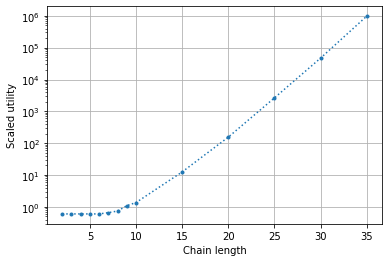

In [12]:
plt.figure()
plt.yscale('log')
plt.plot(Ms, values_scaled, '.:')
plt.xlabel('Chain length')
plt.ylabel('Scaled utility')
plt.grid()

Here we plot the maximum coalition size with positive task rate in the optimal solution. As we can see, there is a transition from small coalitions to large coalitions at chain length = 6.

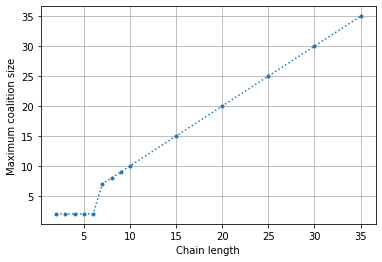

In [13]:
plt.figure()
plt.plot(Ms, maxcoals, '.:')

plt.xlabel('Chain length')
plt.ylabel('Maximum coalition size')
plt.grid()

Here we plot the vector of output entanglement rates from the network. Pairs of nodes with higher output entanglement rates are connected by darker edges. 

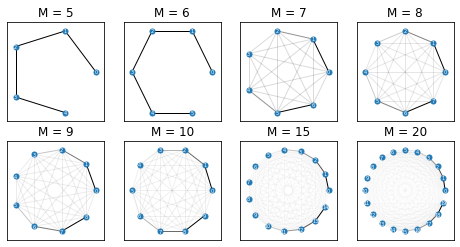

In [14]:
shift = 3
plt.figure(figsize = (8, 4))
for i in range(8):
    chain_length = Ms[i+shift]
    plt.subplot(2, 4, i+1)
    G = graphs[i+shift]
    if G is None: 
        continue
    else:
        Gpos = graph_pos[i+shift]
        nx.draw_networkx_nodes(G, Gpos, node_size = 25)
        nx.draw_networkx_labels(G, Gpos, \
                                labels = {node: str(node) for node in G.nodes}, \
                                font_color = 'w', font_size = 5)
        edgelist = []
        edgecolors = []
        for edge in G.edges:
            edgelist.append(edge)
            edgecolors.append(G.edges[edge]['y'])
        max_y = max(edgecolors)
        edgecolors = [(0, 0, 0, y/max_y) for y in edgecolors]
        nx.draw_networkx_edges(G, Gpos, edgelist = edgelist, edge_color = edgecolors)
    plt.title('M = '+str(chain_length))

### Other topologies

Here we provide a construction of a square grid, if you would like to compute the network volume for a grid quantum network!

(You should use `gen_all_coalitions` in place of `gen_coalitions_chain` to generate the coalitions of interest. This computation may take a while to run, even for the smallest non-trivial grid size.)

In [15]:
def gen_params_grid(half_length, f_edge, q_node, vol_scaling):
    # Only square grids, with an odd number of grid points per side.
    nodes = [(i, j) for i in range(-half_length, half_length+1) \
             for j in range(-half_length, half_length+1)]
    ecal = get_ecal(nodes)
    f_edges = {((i, j), (i+1, j)): f_edge for i in range(-half_length, half_length) \
               for j in range(-half_length, half_length+1)} | \
               {((i, j), (i, j+1)): f_edge for i in range(-half_length, half_length+1) \
                for j in range(-half_length, half_length)}
    q_nodes = {node: q_node for node in nodes}
    return nodes, ecal, f_edges, q_nodes, vol_scaling